### Deep Learning in the Eye Tracking World 
#### the tutorial presented during ETRA 2021 (https://etra.acm.org/2021/acceptedtutorials.html)
#### the code downloaded from: https://github.com/kasprowski/etra2021
@author: pawel@kasprowski.pl


# Convert eye tracking data to images and use images to perform CNN classification

In [1]:
import numpy as np
import os
import cv2

from sklearn.metrics import classification_report,confusion_matrix, accuracy_score, cohen_kappa_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import class_weight
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping

from tensorflow.keras.layers import Activation,Conv2D,Dense,Dropout,Flatten,MaxPooling2D,BatchNormalization
from tensorflow.keras.models import Sequential

## Convert eye tracking data to images

In [2]:
def convert_txt_to_img(indir,outdir):
    if not os.path.exists(outdir):
        os.makedirs(outdir)
    i=0
    added = 0
    samplesIMG = []
    namesIMG = []
    # loading txt files from indir
    for file in os.listdir(indir):
        sample = np.genfromtxt(os.path.join(indir, file), delimiter=',', skip_header=1)
        #print("{}. {} - {}".format(i,file,sample.shape))
        if sample.shape[0]>100:
            samplesIMG.append(sample)
            namesIMG.append(file)
            added+=1
        i+=1
    print(f"Added {added} of {i}")    

    # for each file create an image with blurred gaze points and save it to outdir
    for j in range(len(samplesIMG)):
        img = np.zeros((108,192))
        s = samplesIMG[j]
        for i in range(s.shape[0]):
            x = int(s[i,3]/10)
            y = int(s[i,4]/10)
            #print("{} {},{}".format(s[i,0],x,y))
            if x>=0 and y>=0 and x<192 and y<108:
                img[y,x] = 255

        img = cv2.GaussianBlur(img,(9,9),5)        
        cv2.imwrite(outdir+'/'+namesIMG[j]+".jpg", img)
    print("Images saved to ",outdir
         )
convert_txt_to_img("radio","radio_img")

Added 611 of 611
Images saved to  radio_img


## Load data (images)

In [3]:
def load_img(indir):
    samples = []
    labels = []
    names = []
    for file in os.listdir(indir):
        sample = cv2.imread("{}/{}".format(indir,file))
        sample = cv2.cvtColor(sample, cv2.COLOR_BGR2GRAY)
        sample = cv2.resize(sample,(192,108))
        samples.append(sample)
        labels.append(file[:1])
        names.append(file[:-4])
    samples = np.array(samples)
    labels = np.array(labels)
    return samples,labels,names

samples,labels,_ = load_img("radio_img")
print("shape = {}".format(samples.shape))

#add the fourth dimension (color)
samples = np.expand_dims(samples, axis=3)

print("shape = {}".format(samples.shape))
inputShape = (samples.shape[1],samples.shape[2],samples.shape[3])
print("inputShape = {}".format(inputShape))


shape = (611, 108, 192)
shape = (611, 108, 192, 1)
inputShape = (108, 192, 1)


## Calculate weights and perform one-hot encoding

In [4]:
#weights
class_weights = class_weight.compute_class_weight('balanced',classes=np.unique(labels),y=labels)
d_class_weights = dict(enumerate(class_weights))
print("weights {}".format(d_class_weights))

#one-hot encoding
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
classesNum= labels.shape[1]
print ("Classes: {}".format(classesNum))


weights {0: 1.64247311827957, 1: 1.1252302025782688, 2: 0.6655773420479303}
Classes: 3


## Create and compile the CNN model

In [5]:
def cnn_model(inputShape,numClasses):
    model = Sequential()
    model.add(Conv2D(16, (3, 3), padding="same",input_shape=inputShape))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), padding="same",input_shape=inputShape))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(256))
    model.add(Activation("sigmoid"))
    model.add(Dense(numClasses))
    model.add(Activation("softmax"))

    loss='categorical_crossentropy'    
    model.compile(loss=loss, optimizer="adam",metrics=['accuracy'])
    return model
model = cnn_model(inputShape,classesNum)

In [6]:
#split to training and test
(trainSamples, testSamples, trainLabels, testLabels) = train_test_split(samples, labels, test_size=0.25, random_state=42)

In [7]:
## callbacks
callback1 = ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5', save_best_only=True)
callback2 = EarlyStopping(monitor='val_loss', patience=3)

EPOCHS=20
BATCH=32
H = model.fit(trainSamples, trainLabels, batch_size=BATCH, epochs=EPOCHS,class_weight=d_class_weights,verbose=1,
              callbacks = [callback1,callback2],
              validation_data=(testSamples,testLabels))
    


Epoch 1/20
15/15 [==============================] - 7s 497ms/step - loss: 3.9042 - accuracy: 0.5175 - val_loss: 3.0354 - val_accuracy: 0.5425
Epoch 2/20
15/15 [==============================] - 8s 526ms/step - loss: 2.5153 - accuracy: 0.6070 - val_loss: 1.9586 - val_accuracy: 0.5490
Epoch 3/20
15/15 [==============================] - 7s 500ms/step - loss: 1.4647 - accuracy: 0.6310 - val_loss: 1.0076 - val_accuracy: 0.5817
Epoch 4/20
15/15 [==============================] - 8s 564ms/step - loss: 0.8340 - accuracy: 0.5611 - val_loss: 0.8379 - val_accuracy: 0.4902
Epoch 5/20
15/15 [==============================] - 8s 556ms/step - loss: 0.7512 - accuracy: 0.4629 - val_loss: 0.8019 - val_accuracy: 0.6275
Epoch 6/20
15/15 [==============================] - 8s 562ms/step - loss: 0.7051 - accuracy: 0.6616 - val_loss: 0.7899 - val_accuracy: 0.5490
Epoch 7/20
15/15 [==============================] - 8s 563ms/step - loss: 0.6872 - accuracy: 0.5939 - val_loss: 0.7871 - val_accuracy: 0.5817
Epoch 

In [8]:
cnnResults = model.predict(testSamples)

print(confusion_matrix(testLabels.argmax(axis=1), cnnResults.argmax(axis=1)))
print(classification_report(testLabels.argmax(axis=1), cnnResults.argmax(axis=1)))
cnnAcc = accuracy_score(testLabels.argmax(axis=1), cnnResults.argmax(axis=1))
print("Accuracy CNN: {:.2f}".format(cnnAcc))
print("Cohen's Kappa {:.2f}".format(cohen_kappa_score(testLabels.argmax(axis=1), cnnResults.argmax(axis=1))))

[[28  1  7]
 [ 4 24 23]
 [ 5 14 47]]
              precision    recall  f1-score   support

           0       0.76      0.78      0.77        36
           1       0.62      0.47      0.53        51
           2       0.61      0.71      0.66        66

    accuracy                           0.65       153
   macro avg       0.66      0.65      0.65       153
weighted avg       0.65      0.65      0.64       153

Accuracy CNN: 0.65
Cohen's Kappa 0.45


Text(0, 0.5, 'Accuracy')

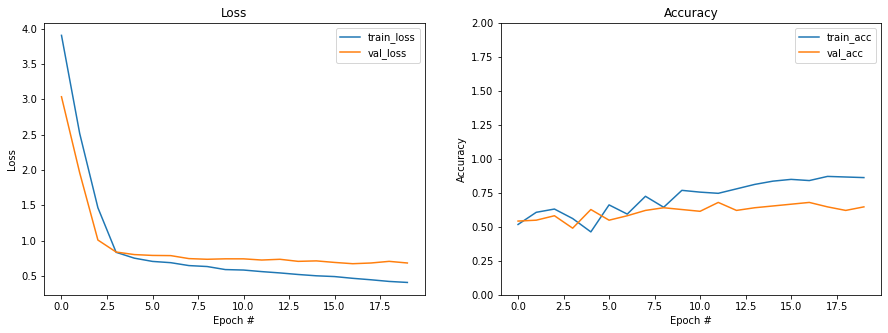

In [9]:
import matplotlib.pyplot as plt

fig=plt.figure(figsize=(15,5))
ax = plt.subplot(1, 2, 1)
plt.plot(H.history["loss"], label="train_loss")
plt.plot(H.history["val_loss"], label="val_loss")
plt.legend()
plt.title("Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")

ax = plt.subplot(1, 2, 2)
plt.plot(H.history["accuracy"], label="train_acc")
plt.plot(H.history["val_accuracy"], label="val_acc")
plt.ylim(0,2)
plt.legend()
plt.title("Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
